In [1]:
import MyTrainer as T
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from torch.optim import Adam, RMSprop, SGD
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset,random_split
import os
from torchvision.transforms import Resize, ToTensor, RandomHorizontalFlip, Normalize,Compose,Scale
from torch.utils.data.sampler import SubsetRandomSampler
from  PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from torchvision.utils import make_grid

In [2]:
# !unzip all_data.zip

In [3]:
os.listdir()

['MyTrainer.py',
 '__pycache__',
 'test_ids_only.csv',
 'all_data.zip',
 'all_data',
 '.ipynb_checkpoints',
 'sample_submission.csv',
 'train_ids_labels.csv',
 'pot_hole_ai.ipynb']

In [153]:
train_df = pd.read_csv('train_ids_labels.csv')
test_df = pd.read_csv('test_ids_only.csv')
submission = pd.read_csv('sample_submission.csv')

In [5]:
train_df

,Image_ID,Label
0,cVOfkSdqnWXUerr,0
1,EhnvIDPXFFjUhkR,0
2,tYKqoStvHsryFhS,1
3,eSpjlsZIwOMLmUS,1
4,uzxhIXjNENLyHwZ,1
...,...,...
4021,HPmIRNZNYnJGtHp,1
4022,tXgGJzdKiOuKOZZ,0
4023,bJNJEzeYfmPTZrm,0
4024,dYyArLoquZIFCTh,1


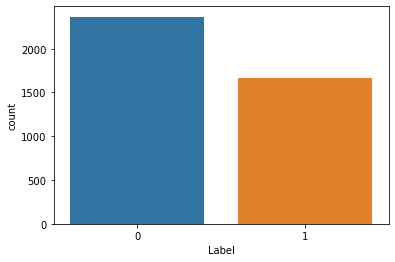

In [6]:
sns.countplot(train_df['Label'])

In [7]:
train_df['Label'].value_counts()

0    2365
1    1661
Name: Label, dtype: int64

In [8]:
t_maj = train_df[train_df.Label==0]
t_min = train_df[train_df.Label==1]

#Upsample minority class
df_minority_upsampled = resample(t_min, 
                                 replace=True,     # sample with replacement
                                 n_samples=t_maj.shape[0],    # to match majority class
                                 random_state=123) # reproducible results
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([t_maj, df_minority_upsampled])
 
# Display new class counts
df_upsampled.Label.value_counts()

1    2365
0    2365
Name: Label, dtype: int64

In [9]:
train_df =  df_upsampled

In [10]:
train_df

,Image_ID,Label
0,cVOfkSdqnWXUerr,0
1,EhnvIDPXFFjUhkR,0
5,hezYtxLhHStWATz,0
7,RiWvALRpGwyReTK,0
8,kYQZTGpDvwXUZlu,0
...,...,...
3792,tALPXkwcBCCteRo,1
2815,vgnDhbVDajFneiB,1
3729,kJnxDBoHiWlREHN,1
1259,iIhxxYrxdeAsZxr,1


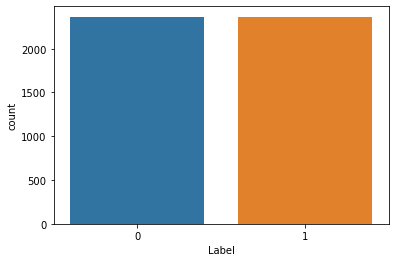

In [11]:
sns.countplot(train_df.Label)

In [12]:
root_dir = 'all_data'

In [13]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self):
        return len(self.annotations)
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
#         image = io.imread(img_path)
        image = Image.open(img_path+'.JPG')
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))
        if self.transform:
            image = self.transform(image)
        return image, y_label

In [14]:
trans = Compose([
    Resize((128, 128)),
    RandomHorizontalFlip(),
    ToTensor(),
    Normalize(mean=(0.5,), std=(0.5,))
])


In [15]:
training_set = CustomDataset('train_ids_labels.csv', root_dir, trans)

In [16]:
training_set.__len__()

4026

In [17]:
def cal_out_shape(w, k, s,ops='conv'):
#     conv or pool
    if ops == 'conv':
        p = (k-1) // 2
        o = ((w-k +2*p)//s) +1
        return dict(output= o, padding = p)
    else:
        o = ((w-k)//s + 1)
        return o

In [18]:
cal_out_shape(32, 2, 2,ops='pool')

16

In [19]:
cal_out_shape(32, 3, 1)

{'output': 32, 'padding': 1}

In [20]:
class PHNET(nn.Module):
    def __init__(self):
        super().__init__()
    
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1), # out: 64*128*128
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2) # out: 64*64*64
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1), # out: 64*64*64
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2) # out: 32*32*32
        )
        
        ##################[ RESIDUAL BLOCK 1 ]###################################
        self.res1conv1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1 ), # out: 32*32*32
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        
        self.res1conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1 ), # out: 32*32*32
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        
        ##################[ RESIDUAL BLOCK 2 ]###################################
        self.res2conv1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1 ), # out: 32*32*32
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        
        self.res2conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1 ), # out: 32*32*32
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

         ##################[ RESIDUAL BLOCK 3 ]###################################
        self.res3conv1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1 ), # out: 32*32*32
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        
        self.res3conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1 ), # out: 32*32*32
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        
        self.G_avg_pool = nn.MaxPool2d(2,2) # out: 32*16*16
        
        in_fc = 32*16*16
        
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_fc, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            
            nn.Linear(128, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            
            nn.Linear(32,2)
        )
        
        
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)

        #<----- [ Implementing residual operaton] ---->

        r1c1 = self.res1conv1(out)
        r1c2 = self.res1conv2(r1c1)

        r2c1 = self.res2conv1(out+r1c2)
        r2c2 = self.res2conv2(r2c1)

        r3c1 = self.res3conv1(r2c2 + r1c2)
        r3c2 = self.res3conv2(r3c1)

        r_final = r3c2 + r2c2

        g_p_out = self.G_avg_pool(r_final)

        fc_out = self.fc(g_p_out)

        return fc_out
            
            
        
        

In [21]:
16384/(32*16*16)

2.0

In [22]:
model = PHNET()

In [23]:
model

PHNET(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1conv1): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (res1conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): R

In [24]:
seb_trainer = T.SebTorchTrainer(model, 'Pot Hole Vision')

In [25]:
seb_trainer.trainable_neurons()

'<<<<<<----Trainable neurons for Pot Hole Vision Computer Vision Model : 4441410 ---->>>>>'

In [26]:
train_ds, valid_ds = seb_trainer.spliter(0.8,training_set)

In [27]:
len(train_ds), len(valid_ds)

(3221, 805)

In [28]:
train_dl, valid_dl = seb_trainer.prepare(valid_ds,train_ds,train_bs=32,valid_bs=32,shuf_train=True, shuf_valid=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
        0, 1, 0, 1, 1, 0, 0, 1])


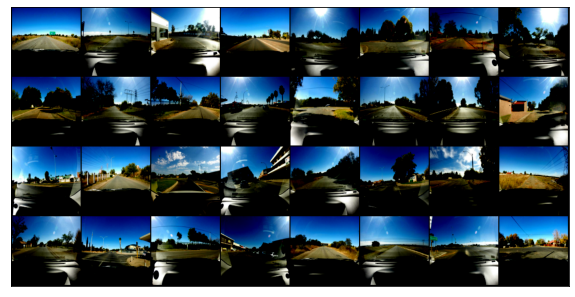

In [62]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(10,10))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, 8).permute(1,2,0))
        break
show_batch(train_dl)

In [30]:
def acc_cus(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.sum( preds == labels ).item() / len(preds)

opt = Adam
ep = 20

In [31]:
%%time
train_losses, train_accs, valid_losses , valid_accs  = seb_trainer.fit(ep,train_dl, valid_dl,loss_func=nn.functional.cross_entropy,metric=acc_cus,opt_func=opt, lr=1e-5)

 Epoch [1/20], training_loss: 0.5419, training_acc: 0.7396, val_loss: 0.4264, val_acc: 0.8536
 Epoch [2/20], training_loss: 0.4233, training_acc: 0.8459, val_loss: 0.3814, val_acc: 0.8829
 Epoch [3/20], training_loss: 0.3685, training_acc: 0.8911, val_loss: 0.3550, val_acc: 0.8913
 Epoch [4/20], training_loss: 0.3381, training_acc: 0.9163, val_loss: 0.3295, val_acc: 0.9123
 Epoch [5/20], training_loss: 0.3095, training_acc: 0.9342, val_loss: 0.3161, val_acc: 0.9255
 Epoch [6/20], training_loss: 0.2881, training_acc: 0.9459, val_loss: 0.3079, val_acc: 0.9255
 Epoch [7/20], training_loss: 0.2702, training_acc: 0.9544, val_loss: 0.2928, val_acc: 0.9178
 Epoch [8/20], training_loss: 0.2509, training_acc: 0.9712, val_loss: 0.2831, val_acc: 0.9339
 Epoch [9/20], training_loss: 0.2352, training_acc: 0.9746, val_loss: 0.2669, val_acc: 0.9531
 Epoch [10/20], training_loss: 0.2220, training_acc: 0.9808, val_loss: 0.2594, val_acc: 0.9459
 Epoch [11/20], training_loss: 0.2113, training_acc: 0.9830

In [32]:
seb_trainer.evaluate(valid_dl, nn.functional.cross_entropy,acc_cus)

{'Acc: 0.9550, loss: 6.2308'}

In [35]:
d = {'train_loss': train_losses, 'train_acc':train_accs, 'valid_loss':valid_losses ,'valid_acc': valid_accs}
result = pd.DataFrame(d)

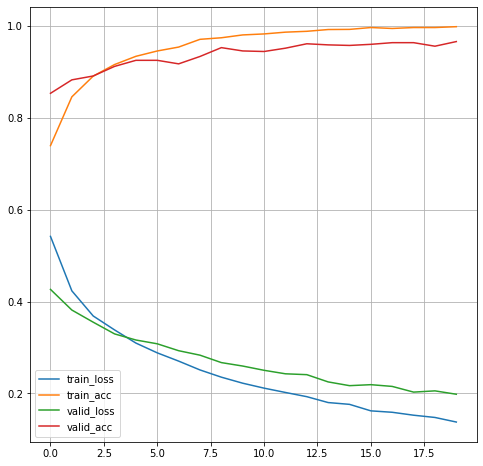

In [48]:
pd.DataFrame(result).plot( figsize=(8,8))
plt.grid(True)
plt.show()

In [51]:
trained_model = seb_trainer.model

In [54]:
class Unseen(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self):
        return len(self.annotations)
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path+'.JPG')
        if self.transform:
            image = self.transform(image)
        return image

In [55]:
test_set = Unseen('test_ids_only.csv', root_dir, trans)

In [ ]:
from torch.utils.data import DataLoader

In [88]:
test_dl = DataLoader(dataset=test_set,batch_size=1)
test_dl_b = DataLoader(dataset=test_set,batch_size=20)

In [190]:
def predictor(model, batch_data, sol_type='prob', show=False):
    with torch.no_grad():
        sol = []
        if sol_type == 'prob':
            for unseen in batch_data:
                output = model(unseen)
                output = F.softmax(output, dim=1)[:,1]
                sol.append(output.item())
            print('<<<<<<<<<<<Done!!! >>>>>>>>>>>>>>>')
        elif sol_type == 'label' and show == False : 
            for unseen in batch_data:
                output = model(unseen)
                output = F.softmax(output, dim=1)
                _, preds = torch.max(output, dim=1)
                sol.append(preds.item())
            print('<<<<<<<<<<<Done!!! >>>>>>>>>>>>>>>')
        elif sol_type == 'label' and show == True:
            for unseen in batch_data:
                output = model(unseen)
                output = F.softmax(output, dim=1)
                _, preds = torch.max(output, dim=1)
                
                for idx, im in enumerate(unseen):
                    res = None
                    if preds[idx] == 0:
                        res = 'No pot hole, path clear '
                    else:
                        res = 'potholes present, be careful'
                    print(res)
                    plt.figure(figsize=(15,15))
                    plt.imshow(im[0], cmap='gray')
                    plt.show()
                
#                 fig = plt.figure(figsize=(25, 4))
#                 for idx, img in enumerate(unseen):

#                     ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
#                     ax.set_title(str(res))
#                     ax.imshow(img[0], cmap='gray')
                    
                break
                
        return sol


In [198]:
p_s = predictor(trained_model, test_dl, sol_type='prob', show=False)

<<<<<<<<<<<Done!!! >>>>>>>>>>>>>>>


In [199]:
my_results = submission.copy()

In [200]:
my_results

,Image_ID,Unnamed: 1,Label
0,nRhHxqLhDlJsiXc,NaN,0.431422
1,gbSntVovxgHQrmO,NaN,0.668000
2,nqOobGmvgEOiPms,NaN,1.000000
3,oIkPTooLcIbZKlF,NaN,0.000000
4,eSKxsTTJDQzkjgD,NaN,NaN
...,...,...,...
1645,BmSrWvzrriPuQOh,NaN,NaN
1646,HfXCITRCHqrLOda,NaN,NaN
1647,uQLYKtTCnvWWGVu,NaN,NaN
1648,gYWbwjUOZrOlTzQ,NaN,NaN


In [201]:
my_results = my_results.drop(['Unnamed: 1'], 1)

In [202]:
my_results['Label'] = p_s

In [203]:
my_results

,Image_ID,Label
0,nRhHxqLhDlJsiXc,0.375161
1,gbSntVovxgHQrmO,0.566662
2,nqOobGmvgEOiPms,0.099116
3,oIkPTooLcIbZKlF,0.871781
4,eSKxsTTJDQzkjgD,0.933208
...,...,...
1645,BmSrWvzrriPuQOh,0.786563
1646,HfXCITRCHqrLOda,0.423365
1647,uQLYKtTCnvWWGVu,0.722954
1648,gYWbwjUOZrOlTzQ,0.384046


In [204]:
my_results.to_csv('res2.csv', index=False)